# Singular Value Decomposition (SVD)

This notebook will look at the implementations of collaborative filtering using SVD under the surprise package for the PSN Recommender system. This model will be applied to user review data obtained from a popular game review site called Metacritic.

We will start by importing the essential libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict
from surprise import SVD
from surprise import NormalPredictor
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV

In [2]:
#Importing the dataset that we will be working with
data = pd.read_csv("metaUserItemAnon.csv")

In [3]:
data.head()

,User_Name,Red Dead Redemption 2,Grand Theft Auto V,Persona 5 Royal,The Last of Us Remastered,God of War,The Last of Us Part II,Persona 5,Metal Gear Solid V: The Phantom Pain,Uncharted 4: A Thief's End,...,Dawn of Fear,Weeping Doll,Tony Hawk's Pro Skater 5,Dino Dini's Kick Off Revival,Ghostbusters,Air Conflicts: Vietnam Ultimate Edition,The Quiet Man,Basement Crawl,Road Rage,Afro Samurai 2: Revenge of Kuma Volume One
0,User 9414,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,User 80765,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,User 51700,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,User 51358,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,User 11752,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
#Converting the data into a form suitable for machine learning, and dropping the cells that have not been rated yet
data = pd.melt(data, id_vars = ["User_Name"])
modelData = data.dropna()
modelData = modelData.rename({'variable': 'Game_Name', 'value': 'Rating'}, axis=1)
modelData.head()

,User_Name,Game_Name,Rating
6,User 293,Red Dead Redemption 2,10.0
11,User 801,Red Dead Redemption 2,1.0
36,User 1120,Red Dead Redemption 2,10.0
145,User 2314,Red Dead Redemption 2,10.0
184,User 2869,Red Dead Redemption 2,9.0


Before we feed our data into the model, we can implement mean normalizaion.
This will improve the quality of recommendations made by the model by helping it to converge and learn faster.

As you will see after the next step, the ratings will be modified to have 0 Mean and will be scaled to the range [0, 1]

In [5]:
max_rating = max(modelData["Rating"])
min_rating = min(modelData["Rating"])
range_ = max_rating - min_rating
modelData["Rating"] =  (modelData["Rating"] - min_rating) / range_
modelData.head()

,User_Name,Game_Name,Rating
6,User 293,Red Dead Redemption 2,1.0
11,User 801,Red Dead Redemption 2,0.1
36,User 1120,Red Dead Redemption 2,1.0
145,User 2314,Red Dead Redemption 2,1.0
184,User 2869,Red Dead Redemption 2,0.9


Lastly, we need to form the train, cross-validation, and test sets. 

We will form the train:val:test sets with a 80:10:10 split (approx). 

There are a few ways the dataset can be split, and the choice depends on what the application aims to achieve. For instance, if I want to avoid encountering a cold-start problem (arises when there exists new users who have not rated any game), I would ensure that my training set contains ratings from every single user and ratings of every single game. 

However, if I want to portray how well my application deals with new users that have no rating history, then I could use random initialization or a combination of random initialization and the above mentioned method to ensure that some users are not included in the training set, but are included in the test set. The former method is a little tricky, while the latter can be achieved by simply using the train_test_split function from the surprise package.

In my case, I will use the former split for two reasons. One, the dataset is already very sparse with majority of the users having rated only a single game, hence I do not want to include dealing with a cold start problem with insufficient data. And two, using this method could improve the recommendations for existing users.

Below I have included the functions I will use in order to perform this split. Note that these functions aren't my own work. I will also link the source below.

https://gist.github.com/tgsmith61591/ce7d614d7a0442f94cd5ae5d1e51d3c2 - Written by Taylor G. Smith

Github Profile : https://gist.github.com/tgsmith61591

I recommend reading the documentation of all the functions in order to understand how it works in general and in the context of this application.

In [6]:
# Author: Taylor G Smith

from __future__ import absolute_import, division

import numpy as np
from abc import ABCMeta, abstractmethod

from sklearn.externals import six
from sklearn.utils.validation import check_random_state
from sklearn.utils import validation as skval

from scipy import sparse

import numbers

__all__ = [
    'BootstrapCV',
    'check_cv',
    'train_test_split'
]

MAX_SEED = 1e6
ITYPE = np.int32
DTYPE = np.float64  # implicit asks for doubles, not float32s...


def check_consistent_length(u, i, r):
    skval.check_consistent_length(u, i, r)
    return np.asarray(u), np.asarray(i), np.asarray(r, dtype=DTYPE)


def _make_sparse_csr(data, rows, cols, dtype=DTYPE):
    # check lengths
    check_consistent_length(data, rows, cols)
    data, rows, cols = (np.asarray(x) for x in (data, rows, cols))

    shape = (np.unique(rows).shape[0], np.unique(cols).shape[0])
    return sparse.csr_matrix((data, (rows, cols)),
                             shape=shape, dtype=dtype)


def to_sparse_csr(u, i, r, axis=0, dtype=DTYPE):
    if axis not in (0, 1):
        raise ValueError("axis must be an int in (0, 1)")

    rows = u if axis == 0 else i
    cols = i if axis == 0 else u
    return _make_sparse_csr(data=r, rows=rows, cols=cols, dtype=dtype)


def _validate_train_size(train_size):
    assert isinstance(train_size, float) and (0. < train_size < 1.), \
        "train_size should be a float between 0 and 1"


def _get_stratified_tr_mask(u, i, train_size, random_state):
    _validate_train_size(train_size)  # validate it's a float
    random_state = check_random_state(random_state)
    n_events = u.shape[0]
    train_mask = random_state.rand(n_events) <= train_size  # type: np.ndarray

    for array in (u, i):
        present = array[train_mask]
        test_vals = array[~train_mask]
        missing = np.unique(test_vals[np.where(
            ~np.in1d(test_vals, present))[0]])

        if missing.shape[0] == 0:
            continue

        array_mask_missing = np.in1d(array, missing)
        where_missing = np.where(array_mask_missing)[0]
        
        added = set()
        for idx, val in zip(where_missing, array[where_missing]):
            if val in added:  # O(1) lookup
                continue
            train_mask[idx] = True
            added.add(val)

    return train_mask


def _make_sparse_tr_te(users, items, ratings, train_mask):
    r_train = to_sparse_csr(u=users[train_mask], i=items[train_mask],
                            r=ratings[train_mask], axis=0)
    r_test = to_sparse_csr(u=users, i=items, r=ratings, axis=0)
    return r_train, r_test


def train_test_split_cf(u, i, r, train_size=0.75, random_state=None):
    users, items, ratings = check_consistent_length(u, i, r)
    train_mask = _get_stratified_tr_mask(
        users, items, train_size=train_size,
        random_state=random_state)
    return _make_sparse_tr_te(users, items, ratings, train_mask=train_mask)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


Before we pass our data into the train_test_split_cf method, we have to encode the users and items such that each user and item can be represented with a single numeric value. This is required by definition of the above functions.

Below I have written a function that will encode the users and items, retrieve the training and test sets by calling the train_test_split_cf method, and then replace the encodings with the original string values after the data has been split. The function will return two dataframes with the specified split size.

In [7]:
def split_dataset(df, train_size = 0.9):
    """Function to create encodings for all users and items in the original dataset.
       The function creates the encoding for all the users and items, and then retrives the user, item,
       and ratings vectors.
       These vectors are then passed into the train_test_split_cf function which returns two arrays corresponding
       to the train and test array.
       These arrays are converted into a dataframe and the encodings are replaced with the original string values.
       
       Parameters:
           df : pandas dataframe, shape(, 3)
           Column names : ["User_Name", "Game_Name", "Rating"]
       
       Returns:
           trainset : pandas dataframe
           testset : pandas dataframe"""
    
    
    #The train_test_split_cf function defined above assumes that ratings with a value of 0 are empty cells.
    #However, this is not the case for this dataset. 
    #Convert the 0 ratings to -1 temporarily to differentiate between empty cells and zeros. 
    #This will be converted back to 0 after the empty cells are removed.
    df["Rating"].loc[df['Rating'] == 0] = -1
    
    #Retrieving all the unique game names
    game_names = df["Game_Name"].unique().tolist()
    #Creating encoding and reverse encoding
    #The encoded data will be used for the train-cv-test splits, and the reverse encodings will be used
    #to convert the data back to the original formate
    gamename_enc = {gamename : enc_value for enc_value, gamename in enumerate(game_names)}
    gamename_rev_enc = {gamename : enc_value for gamename, enc_value in enumerate(game_names)}
    
    #Performing the same steps for the users
    user_names = modelData["User_Name"].unique().tolist()
    username_enc = {username : enc_value for enc_value, username in enumerate(user_names)}
    username_rev_enc = {username : enc_value for username, enc_value in enumerate(user_names)}
    
    #Placing the encodings as separate columns in the dataset and mapping them so they match the other columns
    df["User_Enc"] = df["User_Name"].map(username_enc)
    df["Game_Enc"] = df["Game_Name"].map(gamename_enc)
    
    #Retrieving the vectors for the user and item encodings, and the ratings.
    #These vectors will be fed into the main train_test_split function
    u = np.array(df["User_Enc"])
    i = np.array(df["Game_Enc"])
    r = np.array(df["Rating"])
    
    trainset, testset = train_test_split_cf(u, i, r, train_size=train_size)
    
    #After we have gotten the train and test sets, we use the reverse encodings the convert it back to the original format
    trainset = pd.DataFrame(trainset.toarray())
    testset = pd.DataFrame(testset.toarray())
    
    #Mapping the reverse encodings to the encodings so we have to original game names and usernames
    cols = pd.DataFrame(list(trainset.columns))
    cols.columns = ["Game_Encoding"]
    cols["Games"] = cols["Game_Encoding"].map(gamename_rev_enc)
    gamename_orig = list(cols["Games"])
    
    trainset.columns = gamename_orig
    testset.columns = gamename_orig
    
    usernames = list(username_enc.keys())
    trainset.insert(0, "User_Name", usernames)
    testset.insert(0, "User_Name", usernames)
    
    #Note that the data is in the form of a user item matrix, we will now convert it into a 3 column dataframe 
    #using the melt function and rename the columns
    trainset = pd.melt(trainset, id_vars = ["User_Name"])
    testset = pd.melt(testset, id_vars = ["User_Name"])
    
    trainset.columns = ["User_Name", "Game_Name", "Rating"]
    testset.columns = ["User_Name", "Game_Name", "Rating"]
    
    #Replacing the 0(represents empty entries) values with null so they can be removed from the dataframe
    trainset["Rating"] = trainset["Rating"].replace({0:np.nan})
    testset["Rating"] = testset["Rating"].replace({0:np.nan})
    
    #Retrieving the ratings we converted to -1 to differentiate from the empty entries
    trainset["Rating"].loc[trainset["Rating"] == -1] = 0
    testset["Rating"].loc[testset["Rating"] == -1] = 0
    
    trainset = trainset.dropna()
    testset = testset.dropna()
    
    #Note that the testset contains all the ratings from the trainset and then some extra ratings
    #Dropping the common ratings from the testset
    testset = testset[~testset.isin(trainset)].dropna()
    
    #Now we can return the final train and test datasets
    return trainset, testset

In [8]:
trainset_full, testset = split_dataset(modelData, train_size = 0.9)
trainset, validset = split_dataset(trainset_full, train_size = 0.8)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [9]:
trainset.head()

,User_Name,Game_Name,Rating
0,User 293,Red Dead Redemption 2,1.0
1,User 801,Red Dead Redemption 2,0.1
2,User 1120,Red Dead Redemption 2,1.0
3,User 2314,Red Dead Redemption 2,1.0
4,User 2869,Red Dead Redemption 2,0.9


In [10]:
testset.head()

,User_Name,Game_Name,Rating
18,User 2746,Red Dead Redemption 2,1.0
19,User 3097,Red Dead Redemption 2,1.0
49,User 2047,Red Dead Redemption 2,0.8
56,User 3008,Red Dead Redemption 2,1.0
82,User 968,Red Dead Redemption 2,1.0


In [11]:
#Concatenating the train and validation set for use in GridSearchCV(), which will be introduced later
train_valid = pd.concat([trainset, validset])

Now that we have our final datasets, we can start using the surprise package to make recommendations. We begin by passing it through the reader defined within the package. This converts the dataframe into a form that is convenient for surprise to work with.

The rating scale of our model can be initialized to the range (0,1) since all our ratings now lie in this range.

In [12]:
#Declaring the reader object under the surprise package to specify the rating scale
reader = Reader(rating_scale=(0, 1))

#trainset needs to be converted to surprise trainset format
trainset = Dataset.load_from_df(trainset[['User_Name', 'Game_Name', 'Rating']], reader)

#testset needs to be converted to surprise testset format
testset = Dataset.load_from_df(testset[['User_Name', 'Game_Name', 'Rating']], reader)

#validset is in final format needed for cross validation
validset = Dataset.load_from_df(validset[['User_Name', 'Game_Name', 'Rating']], reader)

#Final dataset we will be using to train using GridSearchCV
train_valid = Dataset.load_from_df(train_valid[['User_Name', 'Game_Name', 'Rating']], reader)

#Converting testset to surprise testset format, this will be the final set used for testing
testset = testset.build_full_trainset()
testset = testset.build_testset()

#training set in surprise trainset format, will be used for model training
trainset = trainset.build_full_trainset()

# Matrix Factorization using SVD

In this section we will run through the details and selection of hyperparameters that make up the SVD model such as the Learning Rate (alpha), Regularization (lambda), and the number of iterations for convergence (epochs).

We can begin to train our model using different values for the hyperparameters. At each choice learning curves will be plotted visualize how the error increases or decreases at different values of each parameter. This will 
help us choose the values that minimizes validation error.

In order to choose these values, we can start at a good estimate for the hyperparameter and increase the value in multiples of 3 or 2 at every iteration. 

You can guess that such a process will take a lot of time to complete for a large dataset. This way of manually doing it is helpful when it comes to visualizing and tweaking our hyperparameters, hence this is what I will primarily focus on.

In case you just want to find the best combination of hyperparameters to use automatically, the surprise package has a function that will do all the work for us, called GridSearchCV(). We can simply specify the range of values for each parameter and pass it through the function, and it will return the combination of values that minimizes validation error. However, when using a large number of values this method becomes computationally expensive and time consuming.

Both of these methods will be implemented below. 

In [13]:
#this is only included to visualize how well the model performs on the training set
train_dict = trainset.build_testset()

In [14]:
#Choosing the learning rate manually

#list of values that we will choose from
alpha_params = [0.0001, 0.0003, 0.0009, 0.001, 0.003, 0.009, 0.01, 0.03, 0.09, 0.1, 0.3, 0.9]

#list of validation errors that will be accumulated and plotted
errors = []

#list of trainset errors that will be accumulated and plotted
train_errors = []

for i in alpha_params:
    algo = SVD(n_epochs = 25, lr_all = i)
    algo.fit(trainset)
    train_predictions = algo.test(train_dict)
    train_errors.append(accuracy.rmse(train_predictions))
    
    #Testing the algorithm on the cross validation sets using 5 fold cross validation
    results = cross_validate(algo, validset, measures=['RMSE'], cv=5, verbose=False)
    results = results["test_rmse"]
    avgError = 0
    for value in results:
        avgError = avgError + value
    avgError = avgError / 5
    
    errors.append(avgError)

RMSE: 0.3614
RMSE: 0.3516
RMSE: 0.3380
RMSE: 0.3359
RMSE: 0.3103
RMSE: 0.2581
RMSE: 0.2505
RMSE: 0.1593
RMSE: 0.1112
RMSE: 0.1091
RMSE: 0.1059
RMSE: 0.5700


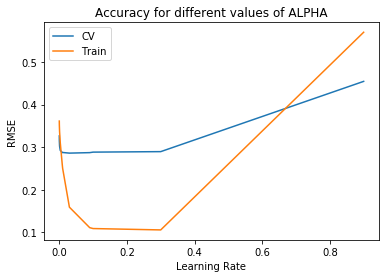

In [15]:
#Visualizing the accuracy of the model with respect to learning rate
plt.plot(alpha_params, errors)
plt.plot(alpha_params, train_errors)
plt.ylabel('RMSE')
plt.xlabel("Learning Rate")
plt.title("Accuracy for different values of ALPHA")
plt.legend(["CV", "Train"])
plt.show()

In [16]:
#Choosing the learning rate that produces minimum error on the CV sets
index = errors.index(min(errors))
alpha = alpha_params[index]
alpha

0.03

In [17]:
#Evaluating the performance of the algorithm at different regularization parameters 
#Brief explanation of regularization : Regularization allows us to either increase or decrease the weight of the-
#parameters used to make predictions. Note that these parameters are different from the hyperparameters used in the-
#model. Tweaking these weights allows to to vary the tradeoff between the bias and variance of the model. Having-
#either a high bias or high variance will not minimize the error of the testset although it may minimize trainset error.
#Hence we need to choose the regularization parameter such that bias and variance is minimized. When this is-
#acheived, we can ensure that our model will generalize well to new data that is provided to it.

#We will use the same values as in the learning parameters for regularization
lambda_params = alpha_params

#list of cv errors that will be used for visualization
errors = []

#list of trainset errors that will be accumulated and plotted
train_errors = []

for i in lambda_params:
    algo = SVD(n_epochs = 25, lr_all = alpha, reg_all = i)
    algo.fit(trainset)
    train_predictions = algo.test(train_dict)
    train_errors.append(accuracy.rmse(train_predictions))
    
    #Testing the algorithm on the cross validation sets using 5 fold cross validation
    results = cross_validate(algo, validset, measures=['RMSE'], cv=5, verbose=False)
    results = results["test_rmse"]
    avgError = 0
    for value in results:
        avgError = avgError + value
    avgError = avgError / 5
    
    errors.append(avgError)

RMSE: 0.0489
RMSE: 0.0537
RMSE: 0.0777
RMSE: 0.0882
RMSE: 0.1228
RMSE: 0.1471
RMSE: 0.1531
RMSE: 0.1674
RMSE: 0.1839
RMSE: 0.1854
RMSE: 0.2015
RMSE: 0.2355


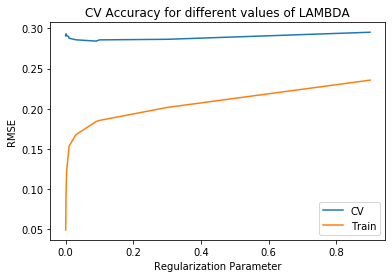

In [18]:
#Plotting a learning curve to visualize the accuracy at different regularization parameters
plt.plot(lambda_params, errors)
plt.plot(lambda_params, train_errors)
plt.ylabel('RMSE')
plt.xlabel("Regularization Parameter")
plt.title("CV Accuracy for different values of LAMBDA")
plt.legend(["CV", "Train"])
plt.show()

In [19]:
index = errors.index(min(errors))
lambda_ = lambda_params[index]
lambda_

0.09

In [20]:
#Evaluating the performance of the algorithm at different number of iterations

epochs_params = [i for i in range(5, 70, 5)]
errors = []

for i in epochs_params:
    algo = SVD(n_epochs = i, lr_all = alpha, reg_all = lambda_)
    algo.fit(trainset)
    
    #Testing the algorithm on the cross validation sets using 5 fold cross validation
    results = cross_validate(algo, validset, measures=['RMSE'], cv=5, verbose=False)
    results = results["test_rmse"]
    avgError = 0
    for value in results:
        avgError = avgError + value
    avgError = avgError / 5
    
    errors.append(avgError)

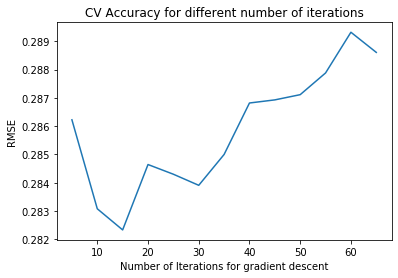

In [21]:
#Visualizing the error at different number of iterations
plt.plot(epochs_params, errors)
plt.ylabel('RMSE')
plt.xlabel("Number of Iterations for gradient descent")
plt.title("CV Accuracy for different number of iterations")
plt.show()

In [22]:
#finalizing the number of iterations
index = errors.index(min(errors))
epochs = epochs_params[index]
epochs

15

Note how the learning rate and number of iterations go hand in hand. The learning rate determines how fast the algorithm converges, and the number of iterations determines how much time it has to converge. If we choose a very small learning rate, the algorithm may not be able to converge within a small number of iterations, but will eventually converge given enough iterations. Hence this step is not absolutely necessecary since we have already chosen a good learning rate, however, it helps to visualize the error at different values for the hyperparameter and could potentially improve our accuracy.

In [23]:
#Reporting all hte parameters that will be used when training our final model
print("Hyperparameters that will be applied to test set : ")
print("Learning Rate (Alpha) :", alpha)
print("Regularization Parameter (Lambda) :", lambda_)
print("Optimal number of iterations for convergence :", epochs)

Hyperparameters that will be applied to test set : 
Learning Rate (Alpha) : 0.03
Regularization Parameter (Lambda) : 0.09
Optimal number of iterations for convergence : 15


# Reporting Testset Accuracy

Test set accuracy with manual parameter selection

In [24]:
algo = SVD(n_epochs = epochs, lr_all = alpha, reg_all = lambda_)
algo.fit(trainset)
predictions = algo.test(testset)
rmse = accuracy.rmse(predictions)

print("RMSE for TestSet :", rmse)

RMSE: 0.2713
RMSE for TestSet : 0.2713219429110023


## Using GridSearchCV

Here I will use GridSearchCV() instead of manually choosing the paramters. I will also be concatenating the train adn validation when fitting the model in this case.

In [25]:
#Initializing the parameter ranges
# epochs_params = [25, 35, 40, 45, 50, 60]
epochs_params = [50]
alpha_params = [0.0003, 0.0009, 0.001, 0.003, 0.009]
lambda_params = alpha_params

#Training the model using GridSearch to find the best combination of parameters
param_grid = {'n_epochs': epochs_params, 'lr_all': alpha_params, 'reg_all': lambda_params}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=2)
gs.fit(train_valid)

print("Best Cross Validation RMSE :", gs.best_score['rmse'])
print("Parameters that provide best RMSE :", gs.best_params['rmse'])

Best Cross Validation RMSE : 0.34270719368626884
Parameters that provide best RMSE : {'n_epochs': 50, 'lr_all': 0.003, 'reg_all': 0.009}


Test set accuracy using GridSearchCV

In [26]:
grid_algo = gs.best_estimator['rmse']
grid_algo.fit(trainset)
grid_predictions = grid_algo.test(testset)
grid_rmse = accuracy.rmse(grid_predictions)

print("RMSE for TestSet using GridSearchCV :", grid_rmse)

RMSE: 0.2790
RMSE for TestSet using GridSearchCV : 0.2789525224462834


The RMSE using GridSearchCV is a little higher than manual selection in this case because I have not tested it using the full range of values, since this function is computationally expensive and time consuming.

We get an RMSE of about 0.27 (may vary due to random initialization of train and test sets) which corresponds to an MSE of 0.072. This is a decent result considering the scale of the ratings. This could be due to the fact that the User-Item matrix is extremely sparse (only about 0.088% of the values are present. This means we have only about 1 rating in every 1000 cells).

One way to confirm this hypothesis is to plot learning curves between the CV error and the number of training examples used, and vary the number of training examples at each iteration. If the error decreases with an increasing number of examples, then we can assume that our hypothesis is correct. Note that when we fit the model to a smaller amount of training data, we are not eliminating the users or the items, we are only eliminating the ratings. In essense, the User-Item matrix remains the same but the dataset becomes more sparse.

The hyperparameters of the model have already been tuned for the best results and hence there is no point spending more time on this aspect of the model to improve the results. We know this because we have already plotted the learning curves for the hyperparameters and inferred the best ones from it. This can also be confirmed by running the model on a smaller subset of the data that is not as sparse as the whole dataset, and you will notice that the results are a lot better compared to the sparse data. Hence we can infer that the choice of parameters are satisfactory.

In the next section we will plot learning curves between the RMSE and trainset size.

In [27]:
#Retrieving the dataframe of train set so we can select fractions of data to train
train_dataframe = trainset.build_testset()
train_dataframe = pd.DataFrame(train_dataframe)
train_dataframe.columns = ['User_Name', 'Game_Name', 'Rating']
train_dataframe.head()

,User_Name,Game_Name,Rating
0,User 293,Red Dead Redemption 2,1.0
1,User 293,The Last of Us Remastered,1.0
2,User 293,Journey,0.9
3,User 293,Rayman Legends,0.9
4,User 293,Dragon Age: Inquisition,1.0


In [28]:
train_size = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
errors = []
train_errors = []

for i in train_size:
    #selecting the fraction of data to train
    train_frac = train_dataframe.sample(frac = i)
    
    #reading the data in a format suitable for surprise 
    train_frac = Dataset.load_from_df(train_frac[['User_Name', 'Game_Name', 'Rating']], reader)
    
    #Converting the data into a surprise trainset
    train_frac = train_frac.build_full_trainset()
    
    #training the model
    algo = SVD(n_epochs = epochs, lr_all = alpha, reg_all = lambda_)
    algo.fit(train_frac)
    
    #converting the training data into surprise testset format so we can test the training data
    train_frac = train_frac.build_testset()
    
    #testing the training data
    train_predictions = algo.test(train_frac)
    train_errors.append(accuracy.rmse(train_predictions))
    
    #testing the test data
    results = algo.test(testset)
    errors.append(accuracy.rmse(results))

RMSE: 0.1664
RMSE: 0.3084
RMSE: 0.1829
RMSE: 0.3049
RMSE: 0.1865
RMSE: 0.2982
RMSE: 0.1897
RMSE: 0.2965
RMSE: 0.1914
RMSE: 0.2968
RMSE: 0.1929
RMSE: 0.2919
RMSE: 0.1934
RMSE: 0.2917
RMSE: 0.1975
RMSE: 0.2927
RMSE: 0.1996
RMSE: 0.2905
RMSE: 0.2019
RMSE: 0.2910
RMSE: 0.2071
RMSE: 0.2860
RMSE: 0.2114
RMSE: 0.2817
RMSE: 0.2174
RMSE: 0.2791
RMSE: 0.2193
RMSE: 0.2780
RMSE: 0.2185
RMSE: 0.2770
RMSE: 0.2208
RMSE: 0.2738
RMSE: 0.2219
RMSE: 0.2719
RMSE: 0.2233
RMSE: 0.2719
RMSE: 0.2342
RMSE: 0.2708


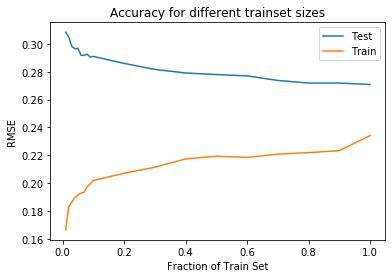

In [29]:
plt.plot(train_size, errors)
plt.plot(train_size, train_errors)
plt.ylabel('RMSE')
plt.xlabel("Fraction of Train Set")
plt.title("Accuracy for different trainset sizes")
plt.legend(["Test", "Train"])
plt.show()

As we can see from the graph above, initially there is a low train error and high test error when the training set is small. This is because as the number of points decreases, it becomes easier to fit the model. Hence, the training error should increase with an increase in the amount of data as seen above. 

As the training size increases, the graph indicates that our data should also be able to generelize well to new data, and hence the test set error decreases athough the train error increases. The train and test accuracy should eventually converge as we get more data from the users. 

#### This confirms our hypothesis that we require more data to make more accurate predictions.

In contrast, if the train and test errors had already converged by now, then obtaining more data would not improve the model.

Lastly, it is worth noting that the decrease in test set error is usually more profound in comparison to this graph. The decrease in test set error is not very prominent in this case because the maximum train set size is not very large to begin with. Also, the data is heavily skewed towards users who have only provided very few ratings and this would also decrease the effects. Again, carrying out this same operation on a subset of this dataset that is not very sparse should confirm this.

# Top-n Predictions using SVD

Now that we have finished training and testing the model with the best parameters, it is time to apply it to check the recommendations made to our user. 

For this we first have to build the set that contains every combination of ratings between the user and the games. 
After this we choose the top 10 predictions and store it in a dataframe to be displayed.

I have not run these lines of code here on the final dataset since it is too large and is not easily handled by my device.

In [ ]:
#Making predictions on all the users after building the whole user-item dataframe
ratings = train.build_anti_testset()
predictions = algo.test(ratings)

In [ ]:
#Function that can be used to return the top_n recommendations
def get_top_n(predictions, n=10):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

#Getting top 10 game predictions for each user
top_n = get_top_n(predictions, n=10)

In [ ]:
#Converting the recommendations into a dataframe and displaying it
user_recommendations = pd.DataFrame(top_n)
user_recommendations.head()